In [1]:
import json
import os
import glob
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
from collections import Counter, defaultdict
import random
import math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))

john16
scr1


In [2]:
DISK_IO_DIR = "/{}/scr1/yiweil".format(machine_name)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)

/john16/scr1/yiweil


In [3]:
og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
os.chdir('../1_data_collection/reddit/convokit')
from customized_fighting_words import FightingWords
os.chdir(og_dir)

# Load ConvoKit corpus

In [4]:
from convokit import Corpus, Speaker
corpus = Corpus(
    filename='/u/scr/yiweil/my-cmv-corpus_1-1-2010_to_09-24-2021')
corpus.print_summary_stats()

Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


In [5]:
# maintain list of generic comments, e.g. "[deleted]", "[removed]" to filter
UTT_THRESHOLD = 50
all_utterance_texts = [
    utt.text[:UTT_THRESHOLD] for utt in corpus.iter_utterances()
]
counted_utts = Counter(all_utterance_texts)
del all_utterance_texts
top_generic_comments = sorted(counted_utts.items(), key = lambda x: x[1], reverse=True)[:40]
top_generic_prefixes = [item[0][:30].lower() for item in top_generic_comments]
del top_generic_comments
to_keep = {'agreed','do you think people have an ob','exactly.','fair enough.','how so?','how?',
          'i agree.','source?','thank you.','thanks!','what?','why?','yes','yes.','∆','','.'}
top_generic_prefixes = set(top_generic_prefixes).difference(to_keep)

# filter out bots
bots = pickle.load(open('../1_data_collection/reddit/bots/bots.pkl','rb'))

In [165]:
top_generic_prefixes

{'!delta',
 '**note:** your thread has **no',
 '1',
 '[deleted]',
 '[removed]',
 'agreed.',
 'confirmed: 1 delta awarded to ',
 "i'm a bot, *bleep*, *bloop*. s",
 'no',
 'no.',
 'removed, see comment rule 1.',
 'thank you!',
 'the moderators have confirmed ',
 'this award is currently disall',
 'this comment has been overwrit',
 'this delta has been rejected. ',
 'this delta is currently disall',
 'what do you mean?',
 'why not?',
 'you cannot award op a delta as',
 'your submission has been autom'}

In [85]:
speaker_names = [corpus.get_speaker(s_id).id for s_id in speaker_ids]

In [91]:
potential_bots = [x for x in speaker_names if type(x) == str and 'bot' in x and 'robot' not in x.lower()
and 'bottle' not in x.lower() and 'bottom' not in x.lower()]

In [6]:
# known_mods = [
#     'hacksoncode',
#     'DeltaBot',
#     'cwenham',
#     'FlyingFoxOfTheYard_',
#     'wyantb',
#     'MystK',
#     'AutoModerator',
#     'Ansuz07'
# ]

# with open('../1_data_collection/reddit/known_cmv_mods.txt','w') as f:
#     for mod in known_mods:
#         f.write(mod+'\n')
        
# Known moderators of r/changemyview listed at: 
# https://www.reddit.com/r/DeltaLog/about/moderators/
with open('../1_data_collection/reddit/known_cmv_mods.txt','r') as f:
    known_cmv_mods = f.read().splitlines()
    
bots = bots | set(known_cmv_mods)

In [7]:
import re
def contains_keyword(s,keyword_set):
    pat = re.compile(r'\b(' + (r'|'.join([kw.replace('*','\*') for kw in keyword_set])) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

def has_generic_utterance_text(utt_idx,generic_spans=top_generic_prefixes):
    return contains_keyword(corpus.get_utterance(utt_idx).text,generic_spans)

def written_by_bot(utt_idx,bot_set=bots):
    return corpus.get_utterance(utt_idx).speaker.id in bot_set

In [8]:
# Update meta to include whether an utterance is generic
# and whether it was written by a likely bot
for utt in corpus.iter_utterances():
    utt.meta['is_generic'] = has_generic_utterance_text(utt.id)
    utt.meta['written_by_bot'] = written_by_bot(utt.id)

In [159]:
# Retrieve authors of generic comments as a way of filtering out bots/moderators
generic_authors = [
    utt.speaker.id for utt in corpus.iter_utterances()
    if utt.meta['is_generic']
]

In [161]:
#Counter(generic_authors)

In [164]:
# print('Number of bots/mods pre-generic comment authors:',len(bots))
# bots = bots | set(generic_authors)
# print('Number of bots/mods post-generic comment authors:',len(bots))

Number of bots/mods pre-generic comment authors: 2812
Number of bots/mods post-generic comment authors: 44677


In [12]:
# for utt in corpus.iter_utterances():
#     utt.meta['written_by_bot'] = written_by_bot(utt.id)

In [232]:
def cleanup(utt_text):
    lines = [line for line in utt_text.splitlines()
             if not line.lstrip().startswith("&gt;")
             and not line.lstrip().startswith("____")
             and "edit" not in " ".join(line.lower().split()[:2])
            ]
    return "\n".join(lines)

In [234]:
#cleanup(utt.text)

# Find climate-change related conversations

In [23]:
import re
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True):
    if ignore_case:
        s = s.lower()
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

with open('../1_data_collection/keywords_high_precision.txt','r') as f:
    CLIMATE_KEYWORDS = f.read().splitlines()
#print(CLIMATE_KEYWORDS)

In [24]:
def get_op(convo_idx):
    return corpus.get_utterance(convo_idx)

def get_op_title(op):
    return op.meta['title']

def get_op_text(op):
    return op.text

In [25]:
climate_convo_idxs = []
for convo in tqdm(corpus.iter_conversations()):
    op_idx = convo.id
    op = get_op(op_idx)
    op_title = get_op_title(op)
    if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
        climate_convo_idxs.append(op_idx)
len(climate_convo_idxs)

84258it [00:01, 66170.38it/s]


637

In [26]:
# Add meta field for whether utterance belongs to climate change-related conversation
for utt in tqdm(corpus.iter_utterances()):
    utt.meta['is_cc_related'] = utt.conversation_id in \
                                set(climate_convo_idxs)

3243830it [01:30, 35930.04it/s]


In [171]:
#convo.print_conversation_structure(lambda utt: utt.text[:80])

## Subsample

Subsample from comments not receiving deltas by:
   * **removing comments from OP(?)**
   * limiting comment depth to odd depths <= 7
   * matching comment time (fixed time window)
   * matching comment order (number of comments before)
   * matching comment length
   * try to represent the same number of different voices/people

In [245]:
climate_utt_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] 
                   and not utt.meta['written_by_bot'] 
                   and utt.text != '[deleted]'
                  and utt.text != '[removed]']
print('Found {} non-deleted comments attached to threads about climate change, excluding bots and mods.'.format(
    len(climate_utt_ixs)))

gen_utt_ixs = [utt.id for utt in corpus.iter_utterances()
                   if not utt.meta['written_by_bot'] 
                   and utt.text != '[deleted]'
                  and utt.text != '[removed]']
print('Found {} non-deleted comments, excluding bots and mods.'.format(
    len(gen_utt_ixs)))

Found 2897475 non-deleted comments, excluding bots and mods.


In [246]:
# Number of comments w/ and w/o deltas
total_with_deltas = len([utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                    and utt.meta['is_awarded_delta']
                        and utt.text != '[deleted]'
                  and utt.text != '[removed]'])
total_without_deltas = len([utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                    and not utt.meta['is_awarded_delta']
                           and utt.text != '[deleted]'
                  and utt.text != '[removed]'])
print('Within climate comments, found {} comments awarded deltas and {} comments without'.format(
    total_with_deltas, total_without_deltas))

gen_total_with_deltas = len([utt.id for utt in corpus.iter_utterances()
                  if not utt.meta['written_by_bot']
                    and utt.meta['is_awarded_delta']
                        and utt.text != '[deleted]'
                  and utt.text != '[removed]'])
gen_total_without_deltas = len([utt.id for utt in corpus.iter_utterances()
                  if not utt.meta['written_by_bot']
                    and not utt.meta['is_awarded_delta']
                           and utt.text != '[deleted]'
                  and utt.text != '[removed]'])
print('Within general comments, found {} comments awarded deltas and {} comments without'.format(
    gen_total_with_deltas, gen_total_without_deltas))

Within general comments, found 31675 comments awarded deltas and 2865800 comments without


In [91]:
# initialize depth dict
# start by getting convo
# then get root to leaf paths
# for each path:
#    index of utt in path is its depth
depth_per_utt = {}
for convo_id in tqdm(corpus.get_conversation_ids()):
    convo = corpus.get_conversation(convo_id)
    paths = convo.get_root_to_leaf_paths()
    for path in paths:
        for i in range(len(path)):
            utt_id = path[i].id
            if utt_id not in depth_per_utt:
                depth_per_utt[utt_id] = i

100%|██████████| 84258/84258 [00:22<00:00, 3740.13it/s] 


In [93]:
for utt in tqdm(corpus.iter_utterances()):
    utt.meta['depth'] = depth_per_utt[utt.id]

3243830it [00:12, 250068.33it/s]


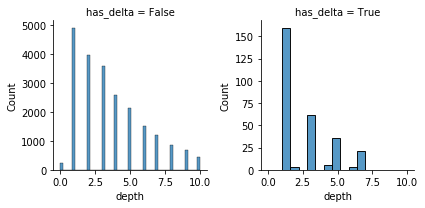

In [232]:
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.meta['depth'],utt.meta['is_awarded_delta']) 
          for utt in corpus.iter_utterances() if utt.meta['is_cc_related']
          and not utt.meta['written_by_bot']
          and utt.text != '[deleted]'
                  and utt.text != '[removed]']

to_plot_df = pd.DataFrame({
    'depth':[item[0] for item in utt_zip],
    'log_depth':[np.log(item[0]+1) for item in utt_zip],
    'has_delta':[item[1] for item in utt_zip],
    
})

#sns.displot(data=to_plot_df, x='depth', col='has_delta', sharey=False)#, multiple='stack')
g = sns.FacetGrid(to_plot_df, col="has_delta", sharey=False)#,  row="sex")
g.map(sns.histplot, "depth")

In [169]:
sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
              and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1]
print('Found {} comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7 (out of {} total).'.format(
    len(sample_ixs), total_with_deltas))

Found 279 comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) with odd depth <= 7 (out of 290 total).


In [170]:
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1]
print('Found {} potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7 for matched sample (out of {} total).'.format(
    len(matched_sample_ixs), total_without_deltas))

Found 11802 potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) with odd depth <= 7 for matched sample (out of 22048 total).


In [105]:
def get_rel_timestamp(utt):
    return utt.timestamp - corpus.get_utterance(utt.conversation_id).timestamp

In [115]:
for utt in tqdm(corpus.iter_utterances()):
    utt.meta['time_diff'] = get_rel_timestamp(utt)

3243830it [00:17, 188480.80it/s]


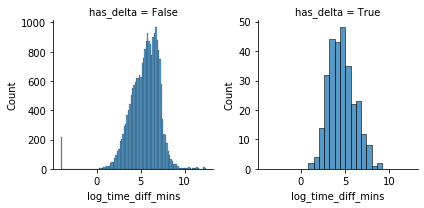

In [233]:
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(get_rel_timestamp(utt),utt.meta['is_awarded_delta']) 
          for utt in corpus.iter_utterances() if utt.meta['is_cc_related']
          and not utt.meta['written_by_bot']
          and utt.text != '[deleted]'
                  and utt.text != '[removed]']

to_plot_df = pd.DataFrame({
    'time_diff_secs':[item[0] for item in utt_zip],
    'time_diff_mins':[item[0]/60 for item in utt_zip],
    'time_diff_hrs':[item[0]/(60*60) for item in utt_zip],
    'log_time_diff_mins':[np.log((item[0]+1)/60) for item in utt_zip],
    'log_time_diff_hrs':[np.log((item[0]+1)/3600) for item in utt_zip],
    'has_delta':[item[1] for item in utt_zip],
    
})

g = sns.FacetGrid(to_plot_df, col="has_delta", sharey=False)#,  row="sex")
g.map(sns.histplot, "log_time_diff_mins")

In [222]:
import math
math.e**8

2980.957987041727

In [223]:
np.log(2980)

7.9996785794994505

In [224]:
math.e**8/60

49.682633117362116

In [173]:
sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
              and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8]
print('Found {} comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP (out of {} total).'.format(
    len(sample_ixs), total_with_deltas))

Found 276 comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP (out of 290 total).


In [174]:
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
                     and np.log((utt.meta['time_diff']+1)/60) <= 8]
print('Found {} potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, for matched sample (out of {} total).'.format(
    len(matched_sample_ixs), total_without_deltas))

Found 11547 potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, for matched sample (out of 22048 total).


In [128]:
def get_utt_order(convo_id, utt_id):
    convo = corpus.get_conversation(convo_id)
    in_order_utt_ids = [utt.id for utt in convo.get_chronological_utterance_list()]
    return in_order_utt_ids.index(utt_id)

for utt in tqdm(corpus.iter_utterances()):
    utt.meta['order'] = get_utt_order(utt.conversation_id, utt.id)

3243830it [18:02, 2997.83it/s]


In [129]:
utt = corpus.get_utterance('t1_fgnl73l')
utt.meta['order']

478

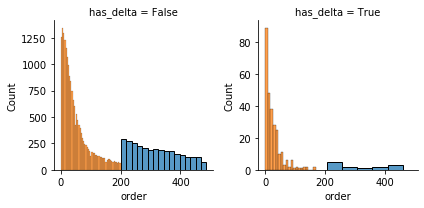

In [243]:
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.meta['order'],utt.meta['is_awarded_delta']) 
          for utt in corpus.iter_utterances() if utt.meta['is_cc_related']
          and not utt.meta['written_by_bot']
          and utt.text != '[deleted]'
                  and utt.text != '[removed]']

to_plot_df = pd.DataFrame({
    'order':[item[0] for item in utt_zip],
    'log_order':[np.log(item[0]+1) for item in utt_zip],
    'has_delta':[item[1] for item in utt_zip],
    'to_keep':[item[0] <= 200 for item in utt_zip]
})

#sns.displot(data=to_plot_df, x='order', hue='has_delta', multiple='stack')
g = sns.FacetGrid(to_plot_df, col="has_delta", sharey=False, hue='to_keep')#, palette=['grey','orange'])#,  row="sex")
g.map(sns.histplot, "order")
g.savefig('figs/delta_v_no_delta_order.png',dpi=200)

In [177]:
sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
              and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200]
print('Found {} comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments (out of {} total).'.format(
    len(sample_ixs), total_with_deltas))

Found 264 comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments (out of 290 total).


In [178]:
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 100
                     and utt.meta['order'] < 200]
print('Found {} potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) \
with depth <= 100, timestamp within 8 log minutes of OP, among first 200 comments for matched sample\
(out of {} total).'.format(
    len(matched_sample_ixs), total_without_deltas))

Found 19134 potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) with depth <= 100, timestamp within 8 log minutes of OP, among first 200 comments for matched sample(out of 22048 total).


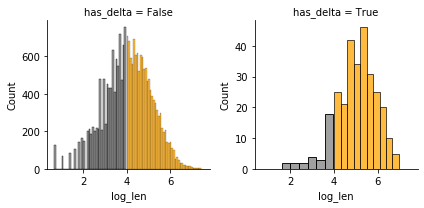

In [240]:
# Distribution of comment lengths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(len(utt.text.split()),utt.meta['is_awarded_delta']) 
          for utt in corpus.iter_utterances() if utt.meta['is_cc_related']
          and not utt.meta['written_by_bot']
          and utt.text != '[deleted]'
                  and utt.text != '[removed]']

to_plot_df = pd.DataFrame({
    'len':[item[0] for item in utt_zip],
    'log_len':[np.log(item[0]+1) for item in utt_zip],
    'has_delta':[item[1] for item in utt_zip],
    'to_keep':[np.log(item[0]+1)>=4 for item in utt_zip]
    
})

#sns.displot(data=to_plot_df, x='log_len', hue='has_delta', multiple='stack')
g = sns.FacetGrid(to_plot_df, col="has_delta", sharey=False, hue='to_keep', palette=['grey','orange'])#,  row="sex")
g.map(sns.histplot, "log_len")
#g._legend.remove()
g.savefig('figs/delta_v_no_delta_len.png',dpi=200)

In [184]:
sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
              and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200
             and np.log(len(utt.text.split())+1) >= 3.5]
print('Found {} comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with \
log length >= 3.5 (out of {} total).'.format(
    len(sample_ixs), total_with_deltas))

Found 253 comments w/ deltas for sample (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with log length >= 3.5 (out of 290 total).


In [204]:
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200
             and np.log(len(utt.text.split())+1) >= 4]
print('Found {} potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with \
log length >= 4 for matched sample (out of {} total).'.format(
    len(matched_sample_ixs), total_without_deltas))

Found 6302 potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with log length >= 4 for matched sample (out of 22048 total).


In [205]:
# Finally, remove comments written by OP
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if utt.meta['is_cc_related'] and not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200
             and np.log(len(utt.text.split())+1) >= 4
                     and utt.speaker.id != corpus.get_utterance(utt.root).speaker.id]
print('Found {} potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with \
log length >= 4, and not written by OP, for matched sample (out of {} total).'.format(
    len(matched_sample_ixs), total_without_deltas))

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.


Found 6102 potential comments w/o deltas (attached to threads about climate change, excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with log length >= 4, and not written by OP, for matched sample (out of 22048 total).


In [206]:
308/6102

0.05047525401507703

In [208]:
delta_ids_in_sample = [utt.id for utt in corpus.iter_utterances() 
                          if utt.meta['is_cc_related']
                           and utt.text != '[deleted]'
                           and utt.text != '[removed]'
                       and not utt.meta['written_by_bot']
                      and utt.meta['is_awarded_delta']]
non_delta_ids_in_sample = [utt.id for utt in corpus.iter_utterances() 
                          if utt.meta['is_cc_related']
                           and utt.text != '[deleted]'
                           and utt.text != '[removed]'
                           and not utt.meta['written_by_bot']
                           and not utt.meta['is_awarded_delta']
                            and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
                            and np.log((utt.meta['time_diff']+1)/60) <= 8
                            and utt.meta['order'] < 200
                            and np.log(len(utt.text.split())+1) >= 4
                            and utt.speaker.id != corpus.get_utterance(utt.root).speaker.id]
print(len(delta_ids_in_sample),len(non_delta_ids_in_sample))

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.


290 6102


In [220]:
[x for x in ids_in_subsample if x[:2] == 't3']

[]

In [210]:
ids_in_subsample = set(delta_ids_in_sample) | set(non_delta_ids_in_sample)
print(len(ids_in_subsample),290+6102)
subsample = corpus.filter_utterances_by(lambda utt: utt.id in ids_in_subsample)

6392 6392


In [212]:
subsample.print_summary_stats()

Number of Speakers: 2704
Number of Utterances: 6392
Number of Conversations: 415


In [213]:
subsample.dump('subsampled_cmv_corpus','/u/scr/yiweil')

In [247]:
# Repeat for general comments

sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if not utt.meta['written_by_bot']
              and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200
             and np.log(len(utt.text.split())+1) >= 3.5]
print('Found {} general comments w/ deltas for sample (excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with \
log length >= 3.5 (out of {} total).'.format(
    len(sample_ixs), gen_total_with_deltas))

# Finally, remove comments written by OP
matched_sample_ixs = [utt.id for utt in corpus.iter_utterances()
                  if not utt.meta['written_by_bot']
                      and utt.text != '[deleted]'
                  and utt.text != '[removed]'
                     and not utt.meta['is_awarded_delta'] and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
             and np.log((utt.meta['time_diff']+1)/60) <= 8
             and utt.meta['order'] < 200
             and np.log(len(utt.text.split())+1) >= 4
                     and utt.speaker.id != corpus.get_utterance(utt.root).speaker.id]
print('Found {} potential general comments w/o deltas (excluding bots and mods) \
with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with \
log length >= 4, and not written by OP, for matched sample (out of {} total).'.format(
    len(matched_sample_ixs), gen_total_without_deltas))

Found 27596 general comments w/ deltas for sample (excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with log length >= 3.5 (out of 31675 total).


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.


Found 731392 potential general comments w/o deltas (excluding bots and mods) with odd depth <= 7, timestamp within 8 log minutes of OP, among first 200 comments, with log length >= 4, and not written by OP, for matched sample (out of 2865800 total).


In [248]:
27596/731392

0.037730792789639485

In [249]:
delta_ids_in_sample = [utt.id for utt in corpus.iter_utterances() 
                          if utt.text != '[deleted]'
                           and utt.text != '[removed]'
                       and not utt.meta['written_by_bot']
                      and utt.meta['is_awarded_delta']]
non_delta_ids_in_sample = [utt.id for utt in corpus.iter_utterances() 
                          if utt.text != '[deleted]'
                           and utt.text != '[removed]'
                           and not utt.meta['written_by_bot']
                           and not utt.meta['is_awarded_delta']
                            and utt.meta['depth'] <= 7 and utt.meta['depth'] % 2 == 1
                            and np.log((utt.meta['time_diff']+1)/60) <= 8
                            and utt.meta['order'] < 200
                            and np.log(len(utt.text.split())+1) >= 4
                            and utt.speaker.id != corpus.get_utterance(utt.root).speaker.id]
print(len(delta_ids_in_sample),len(non_delta_ids_in_sample))

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.


31675 731392


In [250]:
[x for x in ids_in_subsample if x[:2] == 't3']

[]

In [251]:
ids_in_subsample = set(delta_ids_in_sample) | set(non_delta_ids_in_sample)
print(len(ids_in_subsample),31675+731392)
subsample = corpus.filter_utterances_by(lambda utt: utt.id in ids_in_subsample)
subsample.print_summary_stats()

763067 763067
Number of Speakers: 85342
Number of Utterances: 763067
Number of Conversations: 51139


In [252]:
subsample.dump('subsampled_cmv_corpus_general','/u/scr/yiweil')

# Stance labeling

In [71]:
# Select random sample to manually classify
sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# Write to file to manually label
pd.DataFrame({
    'id': sample_convo_ids,
    'title': [corpus.get_utterance(convo_id).meta['title'] 
             if 'title' in corpus.get_utterance(convo_id).meta else -1
             for convo_id in sample_convo_ids],
    'label': [-1]*len(sample_convo_ids)
}).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [57]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

,id,title,label
0,t3_an59pr,CMV: The most ethical course of action is to take very drastic measures to stop climate change,p
1,t3_563ep2,CMV: I will not have kids due to climate change.,ps
2,t3_2ylc5a,CMV:Climate change is a scam by the UN,a
3,t3_ehwa7r,Politicians who don't believe in climate change should not be allowed to hold public office,ps
4,t3_bg5fnj,CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.,an


In [58]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [62]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
an    0.006667
na    0.006667
Name: label, dtype: float64

In [59]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',ax=ax,multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'ax' is not defined

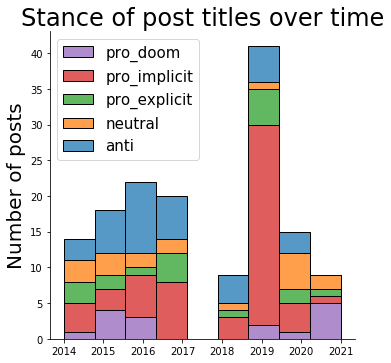

In [63]:
plt.rcParams['figure.figsize'] = [10, 14]
sns.displot(data=sample_with_labels_df.loc[sample_with_labels_df['label']
                                          .isin({'p','ps','pa','a','n'})],x='year',hue='label',multiple='stack',
           hue_order=['a','n','p','ps','pa'],legend=False)
plt.xlabel('')
plt.ylabel('Number of posts',fontsize=20)
plt.title('Stance of post titles over time',fontsize=24)
sns.despine()
plt.legend(title='', loc='upper left', labels=['anti', 'neutral', 'pro_explicit', 'pro_implicit',
                                                                  'pro_doom'][::-1],
          fontsize=15)
plt.savefig('figs/stance_manual_labels_over_time.png',dpi=200,bbox_inches="tight")

# Engagement

In [11]:
ENGAGEMENT_FIELDS = ['score','downs','ups']

In [16]:
random_utt_ids = np.random.choice(corpus.get_utterance_ids(),
                                  size=50000,replace=False)

In [17]:
random_utt_ids[:3]

array(['t1_dfjvasu', 't1_d28yxfk', 't1_fk682gm'], dtype='<U10')

In [ ]:
# First visualize general distributions of engagement signals;
# see how they're correlated with one another

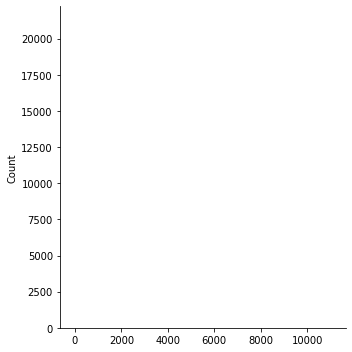

In [20]:
# xs = [corpus.get_utterance(utt_id).meta['ups'] 
#                   for utt_id in random_utt_ids]
sns.displot(
               x=xs
           )
del xs

In [ ]:
sns.displot(
               x=[corpus.get_utterance(utt_id).meta['downs'] 
                  for utt_id in random_utt_ids]
           )

In [ ]:
sns.displot(
               x=[corpus.get_utterance(utt_id).meta['score'] 
                  for utt_id in random_utt_ids]
           )

In [ ]:
sns.scatterplot(x=[corpus.get_utterance(utt_id).meta['ups'] 
                  for utt_id in random_utt_ids],
                y=[corpus.get_utterance(utt_id).meta['downs'] 
                  for utt_id in random_utt_ids]
               )

In [ ]:
sns.scatterplot(x=[corpus.get_utterance(utt_id).meta['ups'] 
                  for utt_id in random_utt_ids],
                y=[corpus.get_utterance(utt_id).meta['score'] 
                  for utt_id in random_utt_ids]
               )

In [ ]:
# Then correlate with features of interest: arousal, NEs

In [ ]:
sns.boxplot(data=,
               x='meta.senti_arousal_cat',
               y='meta.log_ups')

In [ ]:
sns.boxplot(data=,
               x='meta.num_NEs',
               y='meta.log_ups')

# Comments receiving deltas vs. not

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [43]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit','deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

for utt in tqdm(corpus.iter_utterances()):
    utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)

3243830it [00:15, 208123.94it/s]


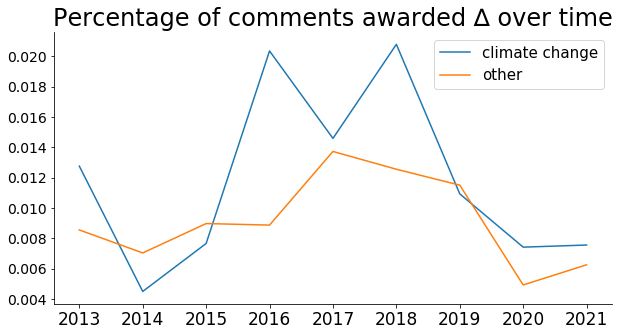

In [225]:
# counts_by_bin = defaultdict(lambda: defaultdict(int))

# for utt in tqdm(corpus.iter_utterances()):
#     if not utt.meta['written_by_bot']\
#     and utt.timestamp:
#         year = datetime.utcfromtimestamp(utt.timestamp).year
#         if utt.meta['is_cc_related']:
#             if utt.meta['is_awarded_delta']:
#                 counts_by_bin[year]['cc_delta'] += 1
#             else:
#                 counts_by_bin[year]['cc_no_delta'] += 1
#         else:
#             if utt.meta['is_awarded_delta']:
#                 counts_by_bin[year]['non_cc_delta'] += 1
#             else:
#                 counts_by_bin[year]['non_cc_no_delta'] += 1
# print(counts_by_bin)

# for year in counts_by_bin:
#     for key in counts_by_bin[year]:
#         print('year:',year)
#         print(key,counts_by_bin[year][key])

years = list(range(2013,2022))
topics = ['climate change','other']
classes = ['awarded delta','not awarded delta']
to_plot_df = pd.DataFrame({
    'year':[item for sublist in 
            [[y]*len(topics)*len(classes) for y in years]
            for item in sublist],
    'topic':[item for sublist in 
            [[t]*len(classes) for t in topics]
            for item in sublist]*len(years),
    'class':classes*len(years)*len(topics),
    'count':[6,464,465,53873,16,3539,2795,394208,19,2460,3494,385645,
            56,2694,3309,369436,43,2903,5193,372894,38,1789,4574,359555,
            61,5516,4010,344344,32,4279,1751,353511,37,4856,2938,466541]
})

per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
to_plot_df['percent'] = to_plot_df.apply(
    lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                        .loc[x['topic']]['count'],
    axis=1
)

plt.rcParams['figure.figsize'] = [10, 5]
sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
           x='year',y='percent',hue='topic')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
plt.legend(title='',fontsize=15)
sns.despine()
plt.savefig('figs/pct_comments_awarded_delta_over_time.png',
            dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [ ]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

In [242]:
deltalog.loc[deltalog['awarded_utt_id']==utt.id]

,logging_utt_id,awarding_utt_id,awarded_utt_id
17281,t1_gzcdhdt,t1_gzcdegz,t1_gzccepc


In [246]:
corpus.get_utterance('t1_gzcdegz').reply_to

't1_gzccepc'

In [244]:
corpus.get_utterance('t1_gzcdegz').text

"> the bottom fell out of the market for the red delicious and the government had to bail out the apple industry, since most growers couldn’t shift production fast enough.\n\nI'm willing to accept this history without question, I may even read your link so a ∆ for you for objective market data on how this apple blows.  It's not just biased personal hatred, apparently."

In [247]:
utt.text

'We actually don’t have many Mac apples around me, so I don’t have strong opinions on it.\n\nBut when I saw the Red Delicious is the lowest common denominator of apples, I mean that in terms of its actual place in the market.   It literally was bred to be the generic “apple” that you can find in any free fruit basket, crappy school and hospital cafeteria, etc.   It’s the mass market product of late 20th century American industrial agriculture.\n\nThe original cultivar of the apple was apparently quite good, which is why it became popular.  And I’m sure if you get some good red delicious apples today that they are from sources closer to those original trees.\n\nBut around the ‘40s and ‘50s, as our food supply chains industrialized, farmers started selecting for strains that were more consistently deep red, because those were the easiest to market, that had thick skins, because those could be more easily shipped, and that had high yields, because those grew more cheaply.   Taste and text

## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Climate change utterances too sparse--first use all CMV

###### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

In [ ]:
PEOPLE = set([
    'greta thunberg',
    'al gore',
    'trump',
    'biden'
])

In [ ]:
all_entities = pickle.load(
    open(os.path.join(DISK_IO_DIR,'entities_by_label.pkl'),'rb'))

In [ ]:
all_entities.keys()

In [ ]:
PEOPLE = all_entities['PERSON']

In [ ]:
fw_all_topics_no_bots = FightingWords()
fw_all.fit(corpus, 
        class1_func = lambda utt: (utt.meta['is_awarded_delta'])\
           and (not utt.meta['written_by_bot']),
        class2_func = lambda utt: (not utt.meta['is_awarded_delta'])\
           and (not utt.meta['written_by_bot']))

In [ ]:
df_all_topics_no_bots = fw_all.summarize(corpus, plot=True, 
                  class1_name='comments awarded deltas', 
                    class2_name='comments not awarded deltas')

In [ ]:
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(PEOPLE)]

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

In [257]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 

result = senti.getSentiment('What a lovely day', score='dual')
print(result)

[(2, -1)]


In [272]:
def get_senti_scores(utts, senti_model, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

In [ ]:
utt_ids = corpus.get_utterance_ids()
all_senti_scores = []

for ix in range(0,len(utt_ids),100):
    utt_ids_batch = utt_ids[ix:min(ix+100,len(utt_ids))]
    #print("Beginning of batch of utt ids:",utt_ids_batch[:5])
    utts_batch = [corpus.get_utterance(utt_id) 
                 for utt_id in utt_ids_batch]
    utts_batch_senti_scores = get_senti_scores([utt.text for utt in 
                                    utts_batch], senti)
    #print(utts_batch_senti_scores)
    all_senti_scores.extend(utts_batch_senti_scores)
    if ix % 1000 == 0:
        print(ix)
    #break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1164000
1165000
1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000


2189000
2190000
2191000
2192000
2193000
2194000
2195000
2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000


In [275]:
assert len(all_senti_scores) == len(utt_ids)
del utt_ids

100

In [ ]:
def assign_senti_cat(senti_res)    
    res_pos, res_neg = senti_res[0], senti_res[1]
    if res_pos == 2:
        return 'lo_pos'
    elif res_pos > 2:
        return 'hi_pos'
    elif res_neg == -2:
        return 'lo_neg'
    elif res_neg < -2:
        return 'hi_neg'
    elif res_pos == 1 and res_neg == -1:
        return 'neut'
    else:
        print("Could not fit sentence within labeling scheme:", 
              senti_res)

In [271]:
for i,utt in enumerate(corpus.iter_utterances()):
    utt.meta['senti_arousal_cat'] = assign_senti_cat(
        all_senti_scores[i])

99it [02:33,  1.55s/it]


KeyboardInterrupt: 

In [ ]:
# Plot distribution of arousal categories for comments
# with hue=delta or not
to_plot_df = utterances_df[['meta.is_awarded_delta',
                            'meta.written_by_bot',
                           'meta.is_cc_related',
                           'senti_arousal_cat']]

sns.displot(data=to_plot_df.loc[~to_plot_df['meta.written_by_bot']],
           x='senti_arousal_cat',
           hue='is_awarded_delta')

### General LOR

In [172]:
fw_all = FightingWords()
fw_no_bots = FightingWords()
fw_no_generic_utts = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.


In [177]:
successful_utt_ids = [utt.id for utt in corpus.iter_utterances()
                     if utt.meta['is_cc_related'] 
                      and utt.meta['is_awarded_delta']]
len(successful_utt_ids)

316

In [178]:
pd.DataFrame({
    'id':successful_utt_ids,
    'text':[corpus.get_utterance(i).text 
           for i in successful_utt_ids]
})

,id,text
0,t1_fai041n,"Her goal is *not* to change the minds of people that disagree with climate change. \n\nFor the most part, that's impossible.\n\nHer goal is to galvanize the people that *agree* with the scientific consensus to organize and fight for action. \n\nWho cares what skeptics and deniers think? They're wrong and they will continue to be wrong. What matters is how hard the majority that believes in science will fight. \n\nI would argue that she's been very effective at that."
1,t1_cfs92i3,"But what if we're not far from a clean coal technology that is better than, say, burning oil or natural gas? Or what if people just use power from oil-burning factories instead? Whatever they use, as population and wealth grows, people will want to consume more energy, so even if the source is a bit cleaner than coal currently is, this can still be a problem. Also, there are some good reasons to think that [reducing consumption of meat](http://www.pbjcampaign.org/) is the most effective way to reduce climate-change-inducing pollution.\n\nThe point being, simply shutting down coal plants may be a good way to cut pollution, but it's not the best way. The best way would be to simply tax pollutants. This creates incentive for energy producers to find cleaner and more efficient ways to produce energy, regardless of whatever the method will be (and we can't predict ahead of time what those methods will be!). And it allows consumers to adjust their energy consumption in the way they each find least burdensome given each person's unique preferences, rather than forcing one way on everyone. [This NYTimes article](http://www.nytimes.com/2013/09/01/business/a-carbon-tax-that-america-could-live-with.html) elaborates further."
2,t1_f99227z,"So i think the reason many people think that socialism will help with climate change is the follows:\n\nSocialist lefties are pro climate activism, they view the industrial complex as the main source of pollution, and if they come to power, and have majority, enough to take over the means of production from individuals, they will have the power to stop the industrial complex from polluting for personal gain."
3,t1_f83z8zi,"There should be some burden, but it doesn't have to be huge. Anyone can shell out a few bucks for some reusable coffee cups. We can all benefit from eating less meat products. It's not a huge inconvenience for us to choose a shared Uber or public transportation. \n\nIf we all take a few small steps, it'll add up."
4,t1_ha1wfoj,You're demanding an experiment for what exactly? This is a question of multiple experiments.\n\nCan we experimentally prove that CO2 concentrations in the atmosphere insulate more solar radiation? Yes. \n\nCan we prove that more insulated solar radiation increase temperatures? Yes.\n\nCan we prove humanity releases inordinate amounts of CO2? Yes.\n\nWhich of these are you saying haven't been proven experimentally?
...,...,...
311,t1_du6w5dd,"I'm a climate scientist. I've worked on the National Climate Assessment and I do a ton of outreach to groups to explain the science to them. I'll do my best.\n\n> Please don’t resort to logical fallacies such as 97% of scientists confirm this(appeal to authority) or what not.\n\nI agree, that proves nothing about the science, but it does rebut a claim we often hear that ""the science isn't settled"" like it's some major point of contention within climate science. It's not. \n\n> Our models still give us only partially accurate short term weather predictions and climate change takes decades and has more unpredictable variables than weather.\n\nPredicting the weather and predicting the climate are entirely different beasts. Short-term prediction is about sorting through that chaos and saying ""This is how Thursday is gonna be."" Climate isn't actually that affected by chaos, because we're talking about long-term statistics, and all of that noise is filtered out. We're not saying ""The high temperature in NYC on October 12, 2048

In [173]:
fw_all.fit(corpus, 
        class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

class1_func returned 316 valid corpus components. class2_func returned 24798 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


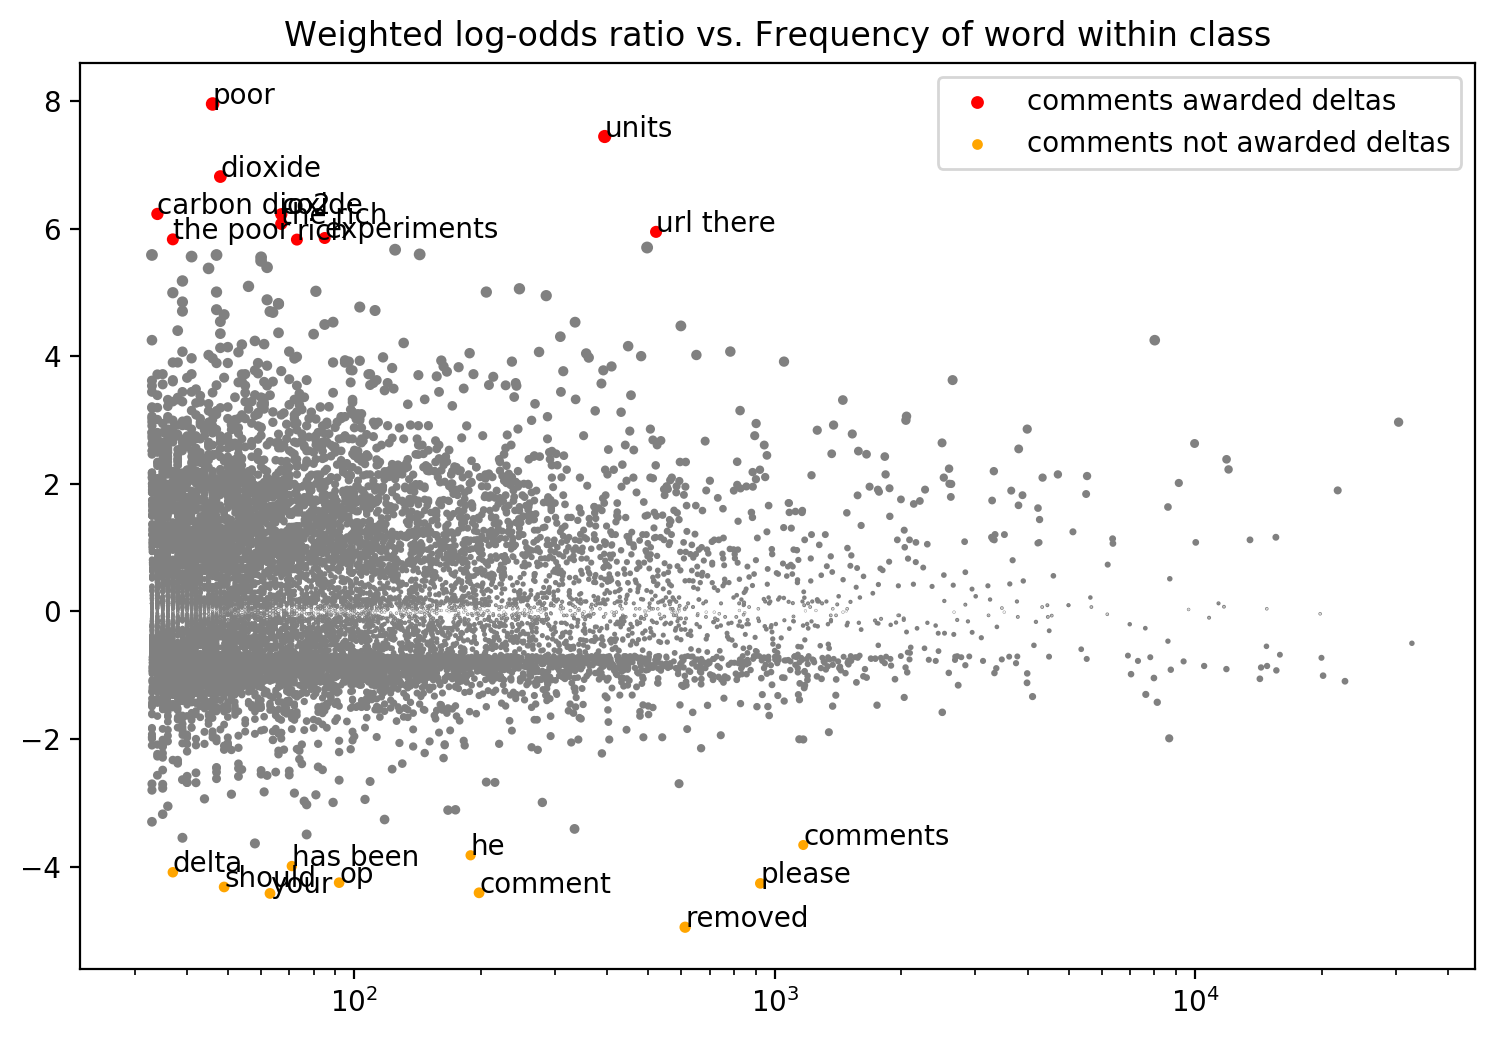

In [174]:
df_all = fw_all.summarize(corpus, plot=True, 
                  class1_name='comments awarded deltas', 
                    class2_name='comments not awarded deltas')

In [175]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
poor,7.952880,comments awarded deltas
units,7.442983,comments awarded deltas
dioxide,6.815170,comments awarded deltas
carbon dioxide,6.229400,comments awarded deltas
co2,6.224359,comments awarded deltas
the rich,6.074059,comments awarded deltas
url there,5.948274,comments awarded deltas
experiments,5.852355,comments awarded deltas
the poor,5.830947,comments awarded deltas


In [36]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
url,8.159434,comments awarded deltas
price,5.007118,comments awarded deltas
wiki,4.684719,comments awarded deltas
carbon taxes,4.506498,comments awarded deltas
the us,4.387404,comments awarded deltas
taxes,4.353331,comments awarded deltas
delta,4.014703,comments awarded deltas
christian,3.990494,comments awarded deltas
cur,3.974307,comments awarded deltas


In [26]:
fw_no_bots.fit(corpus, 
    class1_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 1)\
        and (utt.meta['is_cc_related']),
    class2_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 0)\
        and (utt.meta['is_cc_related']))

class1_func returned 7948 valid corpus components. class2_func returned 16686 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [35]:
# df_no_bots = fw_no_bots.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [28]:
df_no_bots.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
your comment,14.506357,comments awarded deltas
rule,13.996509,comments awarded deltas
clicking,13.927992,comments awarded deltas
by clicking,13.894580,comments awarded deltas
has been removed,13.771117,comments awarded deltas
clicking this link,13.562254,comments awarded deltas
clicking this,13.562254,comments awarded deltas
the moderators by,13.562254,comments awarded deltas
by clicking this,13.562254,comments awarded deltas


In [36]:
# fw_no_generic_utts.fit(corpus, 
#     class1_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 1)\
#         and (utt.meta['is_cc_related']),
#     class2_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 0)\
#         and (utt.meta['is_cc_related']))

In [37]:
# df_no_generic = fw_no_generic_utts.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [32]:
df_no_generic.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
delta,25.117795,comments awarded deltas
explained,20.970349,comments awarded deltas
wiki,20.947304,comments awarded deltas
comments,18.189741,comments awarded deltas
url,17.828676,comments awarded deltas
awarded,16.926767,comments awarded deltas
user,15.951246,comments awarded deltas
your comment,15.176900,comments awarded deltas
note that,15.157092,comments awarded deltas


In [ ]:
# TO DO: better recall in filtering out generic comments

# TO DO: filter by stance

### LOR: high vs. low affect words

In [ ]:
# plot LOR but single out (high) affect-related words


### LOR: words from specific lexicons

In [19]:
# plot LOR but single out words from specific lexicons
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')

In [34]:
EMOLEX.head()

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939


In [150]:
EMOLEX[
    'emotion'
].value_counts()

fear            1765
trust           1564
anger           1483
sadness         1298
joy             1268
disgust         1094
anticipation     864
surprise         585
Name: emotion, dtype: int64

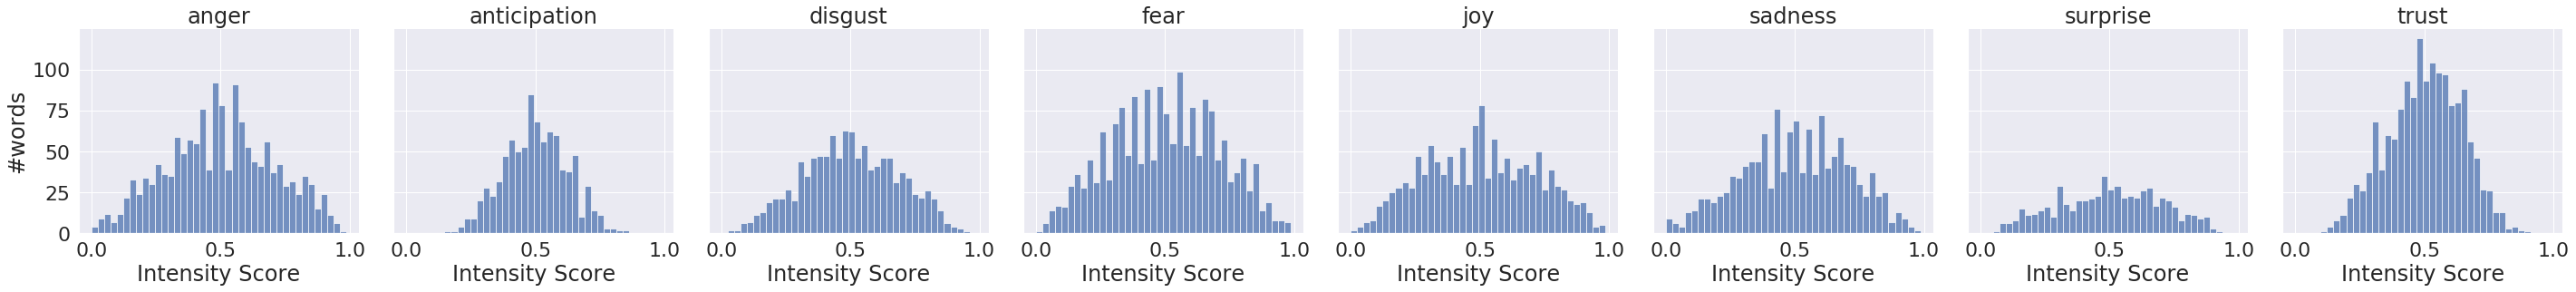

In [28]:
# Plot intensity scores for each emotion category
sns.set(font_scale=2)

g = sns.displot(data=EMOLEX,x='emotion-intensity-score',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [47]:
# Distribution is pretty normal
# Let's threshold to 1.5 stds above the mean to obatin high intensity words in each category
per_emotion_means = EMOLEX.groupby('emotion').mean()
per_emotion_stds = EMOLEX.groupby('emotion').std()

EMOLEX['is_high_intensity'] = EMOLEX.apply(
    lambda x: x['emotion-intensity-score'] >= per_emotion_means['emotion-intensity-score'][x['emotion']], axis=1
)

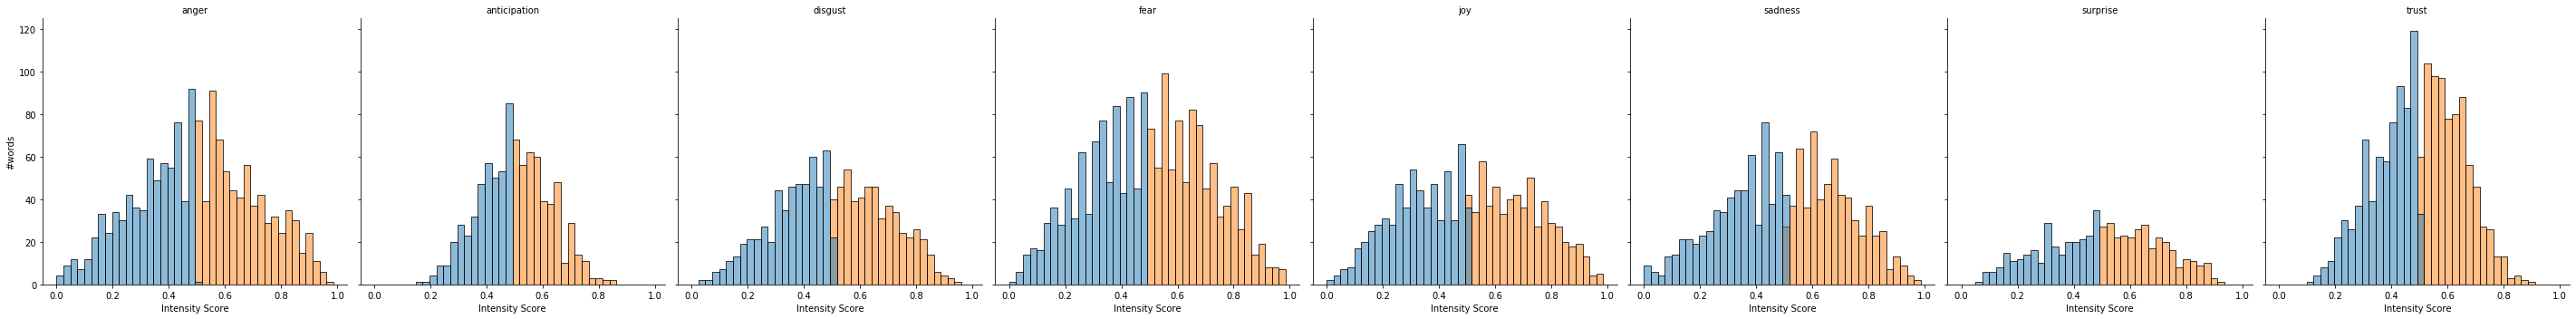

In [48]:
g = sns.displot(data=EMOLEX,x='emotion-intensity-score',hue='is_high_intensity',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
g._legend.remove()

if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [31]:
EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
          (EMOLEX['emotion']=='joy')]['word'].values

array(['happiest', 'happiness', 'bliss', 'celebrating', 'jubilant',
       'ecstatic', 'elation', 'beaming', 'bestdayever', 'loveee',
       'celebration', 'awesomeness', 'joy', 'excitement', 'joyous',
       'happily', 'exuberance', 'makesmehappy', 'euphoria', 'fabulous',
       'lovee', 'gratitude', 'merriment', 'spectacular', 'happydance',
       'purebliss', 'overjoyed', 'triumphant', 'cheerful', 'lovelovelove',
       'ecstasy', 'cheer', 'elated', 'delighted', 'exhilaration',
       'peaceofmind', 'jolly', 'lovethis', 'excitation', 'pleasures',
       'laugh', 'marvelously', 'loving', 'blissful', 'joyful',
       'outstanding', 'pleasurable', 'yaaaay', 'happyplace',
       'overthemoon', 'glee', 'enthusiastic', 'lovinglife', 'iloveher',
       'sohappy', 'laughing', 'superb', 'woohoo', 'wonderful',
       'ilovechristmas', 'cheering', 'magnificent', 'celebrated',
       'hooray', 'loved', 'brilliant', 'hallelujah', 'tearsofjoy',
       'yayyyy', 'glory', 'heavenly', 'exciting', 't

In [49]:
#import importlib
os.chdir('../1_data_collection/reddit/convokit')
#import customized_fighting_words
import importlib
importlib.reload(customized_fighting_words)
from customized_fighting_words import FightingWords
os.chdir(og_dir)

In [50]:
fw_all = FightingWords()
fw_all.fit(corpus, class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 8414 valid corpus components. class2_func returned 16700 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [ ]:
# Distribution of z-scores for high and low intensity words
sns.displot(data=df_all,x=)

In [ ]:
# # no annotations of words or non-of-interest words--too crowded
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [ ]:
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='joy')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='anger')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='disgust')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='fear')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='sadness')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [ ]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='surprise')]['word'].values))].sort_values('z-score',ascending=False).head(20)

# Hypothesis: engaging with opponent is good strategy (agree > disagree chains)

Already tested in other paper and found to be ineffective.

# Topic analysis

## Why do "doom people" think we're doomed?